# 🧠 PART B

### 🔧 **1: Setup, Config & Imports**
📦 Loads essential packages and tools  
⚙️ Defines the Config class for consistent settings  
💡 Enables spaCy GPU usage  
📁 Prepares global configuration for the whole notebook

In [9]:
# %% Cell 1: Setup, Config Class & Imports
import os
import re
import string
import time
import random
import io
import zipfile
from collections import Counter
from typing import Tuple, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import spacy

# Configure spaCy: prefer GPU if available, load the small English model
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Install rouge-score if not installed
!pip install rouge-score
from rouge_score import rouge_scorer

In [10]:
class Config:
    def __init__(self):
        # Global settings
        self.seed = 42
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Hyperparameters
        self.emb_dim = 300
        self.hidden_dim = 300
        self.batch_size = 32
        self.epochs = 10

        # GloVe and data paths
        self.glove_type = '6B'
        self.target_dir = 'data'

# Create a global config instance and print its settings.
config = Config()
print("Config settings:", vars(config))

Using device: cuda
Config settings: {'seed': 42, 'device': device(type='cuda'), 'emb_dim': 300, 'hidden_dim': 300, 'batch_size': 32, 'epochs': 10, 'glove_type': '6B', 'target_dir': 'data'}


### 🧠 **2: Load GloVe Embeddings**
📥 Loads pre-trained GloVe vectors  
🧮 Converts word embeddings into a PyTorch tensor  
🔁 Skips unknown tokens, falls back to random init

In [11]:
def load_glove_embeddings(glove_path: str, vocab: Dict[str, int], emb_dim: int) -> torch.Tensor:
    weights = np.random.normal(0, 0.1, (len(vocab), emb_dim))
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    word, vec = parts[0], np.array(parts[1:], dtype=np.float32)
                    if word in vocab:
                        weights[vocab[word]] = vec
    except Exception as e:
        print(f"Error loading embeddings from {glove_path}: {e}")
    return torch.tensor(weights, dtype=torch.float)

### 🏗️ **3: EncoderRNN (Baseline)**
🧱 Simple GRU-based encoder  
🔁 Uses bidirectional GRU to capture context  
🔌 Has optional GloVe embedding support

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, vocab: Dict[str, int]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab['<pad>'])
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.vocab = vocab

    def forward(self, input_seq: torch.Tensor) -> Tuple[Any, torch.Tensor]:
        try:
            embedded = self.dropout(self.embedding(input_seq))
            _, hidden = self.gru(embedded)
            # Sum the forward and backward hidden states
            hidden = hidden[0] + hidden[1]
            return None, hidden.unsqueeze(0)
        except Exception as e:
            print(f"Error in EncoderRNN forward pass: {e}")
            return None, None

    def load_embeddings(self, glove_path: str, emb_dim: int):
        weights = load_glove_embeddings(glove_path, self.vocab, emb_dim)
        self.embedding.weight.data.copy_(weights)

### 🧬 **4: Hierarchical Encoder (HierEncoderRNN)**
📚 Encodes text at two levels: word → sentence → document  
🔁 Word-level GRU followed by sentence-level GRU  
🧠 Builds document embeddings from sentence states

In [13]:
class HierEncoderRNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, vocab: Dict[str, int]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab['<pad>'])
        self.dropout = nn.Dropout(0.5)
        self.word_gru = nn.GRU(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.sent_gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.hidden_dim = hidden_dim
        self.vocab = vocab

    def forward(self, input_seq: torch.Tensor, inv_vocab: Dict[int, str]) -> Tuple[Any, torch.Tensor]:
        batch_sentence_embeddings = []
        i = 0
        while i < input_seq.size(0):
            seq = input_seq[i]
            # Get indices that are not padding
            indices = seq[seq != self.vocab['<pad>']].tolist()
            # Convert indices to words using inv_vocab
            text = " ".join([inv_vocab.get(tok, '<unk>') for tok in indices])
            # Split text into sentences and filter out empty strings
            sentences = [s.strip() for s in text.split('.') if s.strip()]
            sent_vecs = []
            j = 0
            while j < len(sentences):
                s = sentences[j]
                words = s.split()
                if words:
                    # Build word IDs list using a while loop
                    word_ids_list = []
                    k = 0
                    while k < len(words):
                        w = words[k]
                        word_ids_list.append(self.vocab.get(w, self.vocab['<unk>']))
                        k += 1
                    # Convert list to tensor and move to the proper device
                    word_ids = torch.tensor(word_ids_list).unsqueeze(0).to(input_seq.device)
                    emb = self.dropout(self.embedding(word_ids))
                    _, h = self.word_gru(emb)
                    # Sum the forward and backward GRU hidden states
                    sent_vec = h[0] + h[1]
                    sent_vecs.append(sent_vec.squeeze(0))
                j += 1
            if not sent_vecs:
                sent_vecs.append(torch.zeros((self.hidden_dim,), device=input_seq.device))
            sent_tensor = torch.stack(sent_vecs).unsqueeze(0)
            _, h_sent = self.sent_gru(sent_tensor)
            batch_sentence_embeddings.append(h_sent.squeeze(1))
            i += 1
        # Ensure the final hidden state has shape (num_layers, batch, hidden_dim)
        final_hidden = torch.stack(batch_sentence_embeddings).transpose(0, 1)
        return None, final_hidden

    # Add the load_embeddings method
    def load_embeddings(self, glove_path: str, emb_dim: int):
        weights = load_glove_embeddings(glove_path, self.vocab, emb_dim)
        self.embedding.weight.data.copy_(weights)

### 🔓 **5: DecoderRNN**
🗣️ Standard 1-layer GRU decoder  
🧾 Uses teacher forcing during training  
🔡 Predicts next token in the title sequence

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, vocab: Dict[str, int]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab['<pad>'])
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.vocab = vocab

    def forward(self, input_token: torch.Tensor, hidden: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        emb = self.dropout(self.embedding(input_token.unsqueeze(1)))
        out, hidden = self.gru(emb, hidden)
        return self.fc(out.squeeze(1)), hidden

### 💡 **6: Decoder2RNN**
🧠 Two-layer GRU decoder for better abstraction  
⛓️ Stacked GRUs process input deeper  
🧾 Keeps same interface as baseline decoder

In [15]:
class Decoder2RNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, vocab: Dict[str, int]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=vocab['<pad>'])
        self.dropout = nn.Dropout(0.5)
        self.gru1 = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.vocab = vocab

    def forward(self, input_token: torch.Tensor, hidden: torch.Tensor) -> Tuple[Any, torch.Tensor]:
        try:
            emb = self.dropout(self.embedding(input_token.unsqueeze(1)))
            out1, _ = self.gru1(emb, hidden)
            out2, hidden = self.gru2(out1, hidden)
            output = self.fc(out2.squeeze(1))
            return output, hidden
        except Exception as e:
            print(f"Error in Decoder2RNN forward pass: {e}")
            return None, hidden

### 🧩 **7: Seq2seq Wrapper**
⚙️ Combines encoder & decoder into one model  
🚀 Implements beam search and greedy decoding  
🔁 Manages end-to-end generation

In [16]:
class Seq2seqRNN(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, device: torch.device, 
                 vocab: Dict[str, int], use_hier_encoder: bool = False, use_decoder2: bool = False, 
                 load_embeddings: bool = False, embedding_path: str = None):
        super().__init__()
        if use_hier_encoder:
            self.encoder = HierEncoderRNN(vocab_size, emb_dim, hidden_dim, vocab)
        else:
            self.encoder = EncoderRNN(vocab_size, emb_dim, hidden_dim, vocab)
        if load_embeddings and embedding_path:
            self.encoder.load_embeddings(embedding_path, emb_dim)
        if use_decoder2:
            self.decoder = Decoder2RNN(vocab_size, emb_dim, hidden_dim, vocab)
        else:
            self.decoder = DecoderRNN(vocab_size, emb_dim, hidden_dim, vocab)
        self.device = device
        self.vocab = vocab

    def forward(self, body: torch.Tensor, title: torch.Tensor = None, teacher_forcing_ratio: float = 0.5,
            max_new_tokens: int = 30, inv_vocab: Dict[int, str] = None) -> Tuple[torch.Tensor, bool]:
        # Run the encoder
        if isinstance(self.encoder, HierEncoderRNN):
            _, hidden = self.encoder(body, inv_vocab)
        else:
            _, hidden = self.encoder(body)
        batch_size = body.size(0)
        input_token = torch.full((batch_size,), self.vocab['<bos>'], device=self.device, dtype=torch.long)
        outputs = []
        
        # Use teacher forcing if title is provided and the random condition is met.
        if title is not None and random.random() < teacher_forcing_ratio:
            use_tf = True
        else:
            use_tf = False

        
        # Use a while loop for generating tokens
        t = 0
        while t < max_new_tokens:
            logits, hidden = self.decoder(input_token, hidden)
            outputs.append(logits.unsqueeze(1))
            if use_tf and title is not None and t + 1 < title.size(1):
                input_token = title[:, t + 1]
            else:
                input_token = logits.argmax(dim=1)
            t += 1
        return torch.cat(outputs, dim=1), use_tf

    def generate(self, body: torch.Tensor, max_new_tokens: int = 30, beam_search: bool = False, 
                 beam_width: int = 3, inv_vocab: Dict[int, str] = None) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            if beam_search:
                return self._beam_search(body, beam_width, max_new_tokens, inv_vocab)
            else:
                outputs, _ = self.forward(body, max_new_tokens=max_new_tokens, inv_vocab=inv_vocab)
                return outputs.argmax(dim=2)

    def _beam_search(self, body: torch.Tensor, beam_width: int, max_new_tokens: int, 
                 inv_vocab: Dict[int, str]) -> torch.Tensor:
        if isinstance(self.encoder, HierEncoderRNN):
            _, hidden = self.encoder(body, inv_vocab)
        else:
            _, hidden = self.encoder(body)
        bos_token = self.vocab['<bos>']
        eos_token = self.vocab['<eos>']
        sequences = [[[bos_token], 0.0, hidden]]
        
        t = 0
        while t < max_new_tokens:
            all_candidates = []
            for tokens, score, h in sequences:
                if tokens[-1] == eos_token:
                    all_candidates.append([tokens, score, h])
                    continue
                input_token = torch.tensor([tokens[-1]], device=self.device)
                logits, h_new = self.decoder(input_token, h)
                probs = torch.nn.functional.log_softmax(logits, dim=-1)
                top_probs, top_ids = probs.topk(beam_width)
                for i in range(beam_width):
                    token = top_ids[0][i].item()
                    new_score = score + top_probs[0][i].item()
                    all_candidates.append([tokens + [token], new_score, h_new])
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            t += 1
        best_seq = sequences[0][0]
        return torch.tensor(best_seq, device=self.device).unsqueeze(0)

print("Model definitions have been loaded successfully.")

Model definitions have been loaded successfully.


### 📚 **8: Dataset Class**
🧼 Preprocesses Wikipedia body-title pairs  
🔤 Handles tokenization, padding, truncation  
🔢 Converts text into numerical IDs

In [17]:
class WikiTitleDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: Dict[str, int], max_body_len: int = 500, max_title_len: int = 30):
        self.df = df
        self.vocab = vocab
        self.max_body_len = max_body_len
        self.max_title_len = max_title_len

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[idx]
        body_tokens = row['processed_text'].split()[:self.max_body_len]
        title_tokens = row['title'].split()
        body = [self.vocab.get(tok, self.vocab['<unk>']) for tok in body_tokens]
        title = [self.vocab['<bos>']] + [self.vocab.get(tok, self.vocab['<unk>']) for tok in title_tokens] + [self.vocab['<eos>']]
        return torch.tensor(body), torch.tensor(title[:self.max_title_len])
print("Cell 3 executed successfully.")

Cell 3 executed successfully.


### 🔁 **9: Model Pipeline**
🏭 Full end-to-end model handler  
📥 Downloads GloVe  
🛠️ Builds vocabulary and dataloaders  
🎓 Trains with teacher forcing  
📊 Evaluates using ROUGE  
🧪 Runs ablations for 5 model variants

In [18]:
class ModelPipeline:
    def __init__(self, train_path: str, test_path: str, config: Config, min_freq_ratio: float = 0.01):
        self.train_path = train_path
        self.test_path = test_path
        self.config = config
        self.min_freq_ratio = min_freq_ratio

        self.GLOVE_PATH = self.download_glove_embeddings()
        self.train_df, self.test_df = self.load_data()
        print("Data loading completed.")

        t_preproc = time.time()
        self.preprocess_data()
        print(f"Data preprocessing took {time.time() - t_preproc:.2f} seconds.")

        t_vocab = time.time()
        self.build_vocabulary()
        print(f"Building vocabulary took {time.time() - t_vocab:.2f} seconds.")

        t_dataset = time.time()
        self.create_datasets()
        print(f"Dataset creation took {time.time() - t_dataset:.2f} seconds.")

    def download_glove_embeddings(self) -> str:
        os.makedirs(self.config.target_dir, exist_ok=True)
        glove_path = os.path.join(self.config.target_dir, f'glove.{self.config.glove_type}.{self.config.emb_dim}d.txt')
        if os.path.exists(glove_path):
            return glove_path
        try:
            import requests
            url = f"https://nlp.stanford.edu/data/glove.{self.config.glove_type}.zip"
            response = requests.get(url, stream=True)
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
                target_file = f"glove.{self.config.glove_type}.{self.config.emb_dim}d.txt"
                zip_file.extract(target_file, path=self.config.target_dir)
            return glove_path
        except Exception as e:
            print(f"Error downloading GloVe: {e}")
            return ""

    def load_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        train_df = pd.read_csv(self.train_path)
        test_df = pd.read_csv(self.test_path)
        return train_df, test_df

    @staticmethod
    def preprocess_text(text: str) -> str:
        text = text.lower().encode('ascii', errors='ignore').decode('utf-8')
        text = text.translate(str.maketrans('', '', string.punctuation))
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        return " ".join(tokens)

    def preprocess_data(self) -> None:
        tqdm.pandas(desc="Preprocessing")
        self.train_df['processed_text'] = self.train_df['text'].progress_apply(self.preprocess_text)
        self.test_df['processed_text'] = self.test_df['text'].progress_apply(self.preprocess_text)
        self.validation_df = self.train_df.iloc[:500].copy()
        self.train_df = self.train_df.iloc[500:].reset_index(drop=True)

    def build_vocabulary(self) -> None:
        all_texts = pd.concat([self.train_df['processed_text'], self.train_df['title']])
        counter = Counter()
        for text in all_texts:
            counter.update(text.strip().split())
        min_freq = max(1, int(len(all_texts) * self.min_freq_ratio))
        self.vocab = {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.vocab:
                self.vocab[token] = len(self.vocab)
        self.inv_vocab = {i: w for w, i in self.vocab.items()}

    def create_datasets(self) -> None:
        self.train_dataset = WikiTitleDataset(self.train_df, self.vocab)
        self.val_dataset = WikiTitleDataset(self.validation_df, self.vocab)
        self.test_dataset = WikiTitleDataset(self.test_df, self.vocab)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.config.batch_size, shuffle=True,
                                       collate_fn=self.collate_fn)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.config.batch_size, shuffle=False,
                                     collate_fn=self.collate_fn)

    def collate_fn(self, batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
        bodies, titles = zip(*batch)
        bodies = nn.utils.rnn.pad_sequence(bodies, batch_first=True, padding_value=self.vocab['<pad>'])
        titles = nn.utils.rnn.pad_sequence(titles, batch_first=True, padding_value=self.vocab['<pad>'])
        return bodies, titles

    def train_epoch(self, model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, 
                    criterion: nn.Module, tf_ratio: float) -> float:
        model.train()
        total_loss = 0.0
        for bodies, titles in tqdm(dataloader, desc="Training", leave=False):
            bodies, titles = bodies.to(self.config.device), titles.to(self.config.device)
            optimizer.zero_grad()
            outputs, _ = model(bodies, titles, teacher_forcing_ratio=tf_ratio, 
                                 max_new_tokens=titles.size(1) - 1, inv_vocab=self.inv_vocab)
            targets = titles[:, 1:1 + outputs.size(1)]
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.contiguous().view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def evaluate_model(self, model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> float:
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for bodies, titles in tqdm(dataloader, desc="Evaluating", leave=False):
                bodies, titles = bodies.to(self.config.device), titles.to(self.config.device)
                outputs, _ = model(bodies, titles, teacher_forcing_ratio=0.0,
                                     max_new_tokens=titles.size(1) - 1, inv_vocab=self.inv_vocab)
                targets = titles[:, 1:1 + outputs.size(1)]
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.contiguous().view(-1))
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def compute_rouge(self, model: nn.Module, dataset: Dataset, beam: bool = False, 
                      print_samples: int = 5) -> Dict[str, float]:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
        examples = []
        for i, (body, title) in enumerate(dataset):
            body = body.unsqueeze(0).to(self.config.device)
            pred = model.generate(body, beam_search=beam, inv_vocab=self.inv_vocab).squeeze()
            pred_tokens = [self.inv_vocab.get(t, '<unk>') for t in pred.cpu().tolist() if t not in [0, 1, 2]]
            pred_text = ' '.join(pred_tokens)
            true_tokens = [self.inv_vocab.get(t, '<unk>') for t in title.tolist()[1:-1]]
            true_text = ' '.join(true_tokens)
            result = scorer.score(true_text, pred_text)
            for k in scores:
                scores[k].append(result[k].fmeasure)
            if len(examples) < print_samples:
                examples.append((true_text, pred_text))
        print("\n=== Examples ===")
        for ref, gen in examples:
            print(f"Reference: {ref}\nGenerated: {gen}\n")
        return {k: np.mean(v) for k, v in scores.items()}

    def run_model(self, name: str, use_glove: bool = False, use_hier_encoder: bool = False, 
                  use_decoder2: bool = False) -> Dict[str, Any]:
        print(f"\n===== Running: {name} =====")
        model = Seq2seqRNN(
            vocab_size=len(self.vocab),
            emb_dim=self.config.emb_dim,
            hidden_dim=self.config.hidden_dim,
            device=self.config.device,
            vocab=self.vocab,
            use_hier_encoder=use_hier_encoder,
            use_decoder2=use_decoder2,
            load_embeddings=use_glove,
            embedding_path=self.GLOVE_PATH
        ).to(self.config.device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index=self.vocab['<pad>'])
        best_val_loss = float('inf')
        best_model_state = None
        start_time = time.time()

        for epoch in range(self.config.epochs):
            t_epoch_start = time.time()
            train_loss = self.train_epoch(model, self.train_loader, optimizer, criterion, tf_ratio=0.5)
            val_loss = self.evaluate_model(model, self.val_loader, criterion)
            t_epoch_end = time.time()
            print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Epoch Time={t_epoch_end - t_epoch_start:.2f} s")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
        model.load_state_dict(best_model_state)
        rouge_greedy = self.compute_rouge(model, self.test_dataset)
        rouge_beam = self.compute_rouge(model, self.test_dataset, beam=True)
        print(f"{name} - ROUGE Greedy: {rouge_greedy}")
        print(f"{name} - ROUGE Beam: {rouge_beam}")
        elapsed_time = time.time() - start_time
        print(f"{name} - Total Training & Evaluation Time: {elapsed_time:.2f} seconds\n")
        return {'name': name, 'rouge': rouge_greedy, 'time': elapsed_time}

print("Pipeline class definitions have been loaded successfully.")

Pipeline class definitions have been loaded successfully.


### 🚀 **10: Main Function**
🎬 Runs full training & evaluation for:
1. 🧱 Baseline  
2. 🧠 +GloVe  
3. 🧬 +Hierarchical Encoder  
4. 🔓 +2-layer Decoder  
5. 🧩 Full model  
📈 Visualizes ROUGE & training time

Data loading completed.


Preprocessing: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


Data preprocessing took 948.34 seconds.
Building vocabulary took 3.10 seconds.
Dataset creation took 0.00 seconds.

===== Running: Baseline =====


Epoch 1: Train Loss=0.7062, Val Loss=0.4107, Epoch Time=34.69 s


Epoch 2: Train Loss=0.4317, Val Loss=0.3528, Epoch Time=34.57 s


Epoch 3: Train Loss=0.3893, Val Loss=0.3543, Epoch Time=34.61 s


Epoch 4: Train Loss=0.3538, Val Loss=0.3231, Epoch Time=34.53 s


Epoch 5: Train Loss=0.3193, Val Loss=0.3104, Epoch Time=34.58 s


Epoch 6: Train Loss=0.2917, Val Loss=0.3019, Epoch Time=34.57 s


Epoch 7: Train Loss=0.2710, Val Loss=0.3115, Epoch Time=34.66 s


Epoch 8: Train Loss=0.2508, Val Loss=0.3017, Epoch Time=34.59 s


Epoch 9: Train Loss=0.2365, Val Loss=0.3120, Epoch Time=34.58 s


Epoch 10: Train Loss=0.2193, Val Loss=0.3033, Epoch Time=34.60 s

=== Examples ===
Reference: <unk>
Generated: <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk> <unk>

Reference: <unk>
Generated: <unk>


=== Examples ===
Reference: <unk>
Generated: <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>

Baseline - ROUGE Greedy: {'rouge1': 0.9218766233766235, 'rouge2': 0.7187460317460318, 'rougeL': 0.9198766233766235}
Baseline - ROUGE Beam: {'rouge1': 0.923642857142857, 'rouge2': 0.7205238095238095, 'rougeL': 0.9216428571428571}
Baseline - Total Training & Evaluation Time: 349.27 seconds


===== Running: With_GloVe =====


Epoch 1: Train Loss=0.6946, Val Loss=0.3966, Epoch Time=35.82 s


Epoch 2: Train Loss=0.4325, Val Loss=0.3543, Epoch Time=35.73 s


Epoch 3: Train Loss=0.3702, Val Loss=0.3345, Epoch Time=35.82 s


Epoch 4: Train Loss=0.3307, Val Loss=0.3155, Epoch Time=35.74 s


Epoch 5: Train Loss=0.3076, Val Loss=0.3107, Epoch Time=35.78 s


Epoch 6: Train Loss=0.2833, Val Loss=0.3126, Epoch Time=35.73 s


Epoch 7: Train Loss=0.2608, Val Loss=0.3150, Epoch Time=35.75 s


Epoch 8: Train Loss=0.2423, Val Loss=0.3273, Epoch Time=35.74 s


Epoch 9: Train Loss=0.2264, Val Loss=0.3353, Epoch Time=35.72 s


Epoch 10: Train Loss=0.2072, Val Loss=0.3246, Epoch Time=35.73 s

=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>


=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>

With_GloVe - ROUGE Greedy: {'rouge1': 0.8937756184991479, 'rouge2': 0.6863729923458185, 'rougeL': 0.891775618499148}
With_GloVe - ROUGE Beam: {'rouge1': 0.9166587301587303, 

Epoch 1: Train Loss=0.7432, Val Loss=0.4748, Epoch Time=404.67 s


Epoch 2: Train Loss=0.5452, Val Loss=0.4368, Epoch Time=406.97 s


Epoch 3: Train Loss=0.4703, Val Loss=0.3866, Epoch Time=407.40 s


Epoch 4: Train Loss=0.4004, Val Loss=0.3460, Epoch Time=407.94 s


Epoch 5: Train Loss=0.3495, Val Loss=0.3350, Epoch Time=407.92 s


Epoch 6: Train Loss=0.3202, Val Loss=0.3115, Epoch Time=405.60 s


Epoch 7: Train Loss=0.2946, Val Loss=0.3155, Epoch Time=407.10 s


Epoch 8: Train Loss=0.2759, Val Loss=0.3247, Epoch Time=407.26 s


Epoch 9: Train Loss=0.2626, Val Loss=0.3208, Epoch Time=405.48 s


Epoch 10: Train Loss=0.2391, Val Loss=0.3148, Epoch Time=405.28 s

=== Examples ===
Reference: <unk>
Generated: <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>


=== Examples ===
Reference: <unk>
Generated: <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>

Hier_Encoder - ROUGE Greedy: {'rouge1': 0.9197185592185592, 'rouge2': 0.7087077922077921, 'rougeL': 0.9197185592185592}
Hier_Encoder - ROUGE Beam: {'rouge1': 0.9258571428571429, 'rouge2': 0.7108333333333333, 'rougeL': 0.9238571428571428}
Hier_Encoder - Total Training & Evaluation Time: 4068.99 seconds


===== Running: Decoder2 =====


Epoch 1: Train Loss=0.7548, Val Loss=0.4398, Epoch Time=34.95 s


Epoch 2: Train Loss=0.4824, Val Loss=0.3925, Epoch Time=35.01 s


Epoch 3: Train Loss=0.4113, Val Loss=0.3558, Epoch Time=35.06 s


Epoch 4: Train Loss=0.3777, Val Loss=0.3455, Epoch Time=34.98 s


Epoch 5: Train Loss=0.3506, Val Loss=0.3153, Epoch Time=34.98 s


Epoch 6: Train Loss=0.3276, Val Loss=0.3085, Epoch Time=34.95 s


Epoch 7: Train Loss=0.3030, Val Loss=0.3011, Epoch Time=34.93 s


Epoch 8: Train Loss=0.2847, Val Loss=0.2950, Epoch Time=34.98 s


Epoch 9: Train Loss=0.2686, Val Loss=0.2876, Epoch Time=35.00 s


Epoch 10: Train Loss=0.2519, Val Loss=0.2960, Epoch Time=35.10 s

=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>


=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>

Decoder2 - ROUGE Greedy: {'rouge1': 0.8948291316526611, 'rouge2': 0.6838598484848485, 'rougeL': 0.8928291316526611}
Decoder2 - ROUGE Beam: {'rouge1': 0.9138650793650794, 'rouge2':

Epoch 1: Train Loss=0.7963, Val Loss=0.5666, Epoch Time=408.49 s


Epoch 2: Train Loss=0.6360, Val Loss=0.5664, Epoch Time=408.70 s


Epoch 3: Train Loss=0.6114, Val Loss=0.4949, Epoch Time=409.10 s


Epoch 4: Train Loss=0.5259, Val Loss=0.4182, Epoch Time=409.54 s


Epoch 5: Train Loss=0.4151, Val Loss=0.3592, Epoch Time=409.34 s


Epoch 6: Train Loss=0.3435, Val Loss=0.3083, Epoch Time=409.29 s


Epoch 7: Train Loss=0.3006, Val Loss=0.3168, Epoch Time=409.47 s


Epoch 8: Train Loss=0.2675, Val Loss=0.3026, Epoch Time=410.14 s


Epoch 9: Train Loss=0.2414, Val Loss=0.3074, Epoch Time=409.66 s


Epoch 10: Train Loss=0.2158, Val Loss=0.3188, Epoch Time=409.69 s

=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>


=== Examples ===
Reference: <unk>
Generated: <unk> <unk>

Reference: <unk> <unk> <unk> <unk>
Generated: <unk> <unk> <unk> <unk>

Reference: <unk> <unk> <unk>
Generated: <unk> <unk> <unk>

Reference: <unk> of people <unk> <unk>
Generated: <unk> of people <unk> <unk>

Reference: <unk>
Generated: <unk>

Full_Model - ROUGE Greedy: {'rouge1': 0.8753265249403769, 'rouge2': 0.6525216444197255, 'rougeL': 0.8742154138292658}
Full_Model - ROUGE Beam: {'rouge1': 0.9025634920

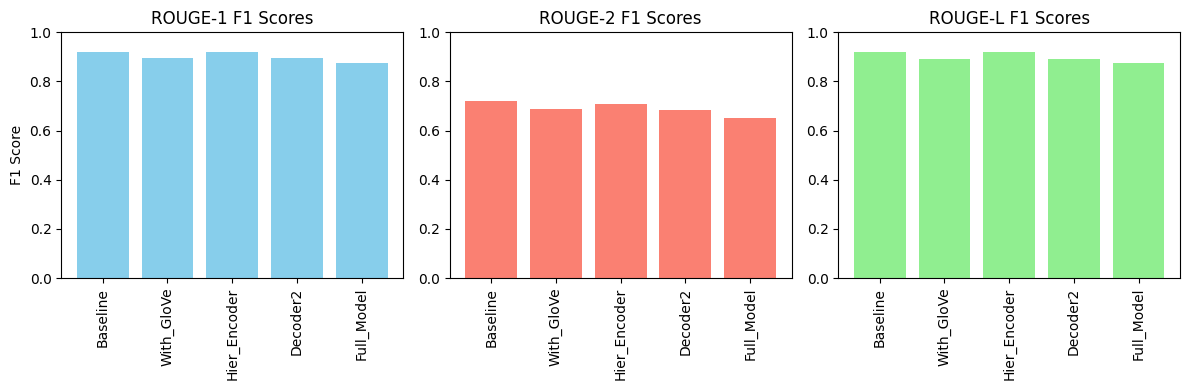

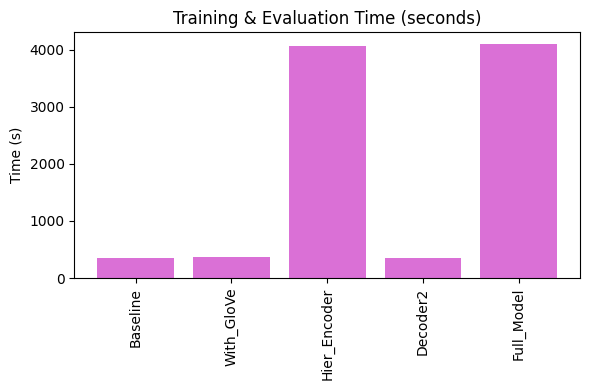

In [19]:
def main():
    # Update these paths as necessary or use your own dataset paths
    train_path = '/kaggle/input/nlp-a2-dataset/train.csv'
    test_path = '/kaggle/input/nlp-a2-dataset/test.csv'
    
    pipeline = ModelPipeline(train_path, test_path, config)
    
    # Run different model configurations.
    results = [
        pipeline.run_model("Baseline"),
        pipeline.run_model("With_GloVe", use_glove=True),
        pipeline.run_model("Hier_Encoder", use_hier_encoder=True),
        pipeline.run_model("Decoder2", use_decoder2=True),
        pipeline.run_model("Full_Model", use_glove=True, use_hier_encoder=True, use_decoder2=True)
    ]
    
    # Plotting results for ROUGE scores
    model_names = [res['name'] for res in results]
    rouge1_scores = [res['rouge']['rouge1'] for res in results]
    rouge2_scores = [res['rouge']['rouge2'] for res in results]
    rougeL_scores = [res['rouge']['rougeL'] for res in results]
    times = [res['time'] for res in results]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.bar(model_names, rouge1_scores, color='skyblue')
    plt.title('ROUGE-1 F1 Scores')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    
    plt.subplot(1, 3, 2)
    plt.bar(model_names, rouge2_scores, color='salmon')
    plt.title('ROUGE-2 F1 Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    
    plt.subplot(1, 3, 3)
    plt.bar(model_names, rougeL_scores, color='lightgreen')
    plt.title('ROUGE-L F1 Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    # Plotting the training and evaluation time for each model
    plt.figure(figsize=(6, 4))
    plt.bar(model_names, times, color='orchid')
    plt.title('Training & Evaluation Time (seconds)')
    plt.ylabel('Time (s)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()